<a href="https://colab.research.google.com/github/Lastget/stock_prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SNP500 prediction
This notebook demenstrate stock prediction using three different time-series models.
- Classical time series model:
- Supervised model:
- Deep learning-based model:

# 1. Get stock market data

In [ ]:
!pip -q install yfinance

In [ ]:
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

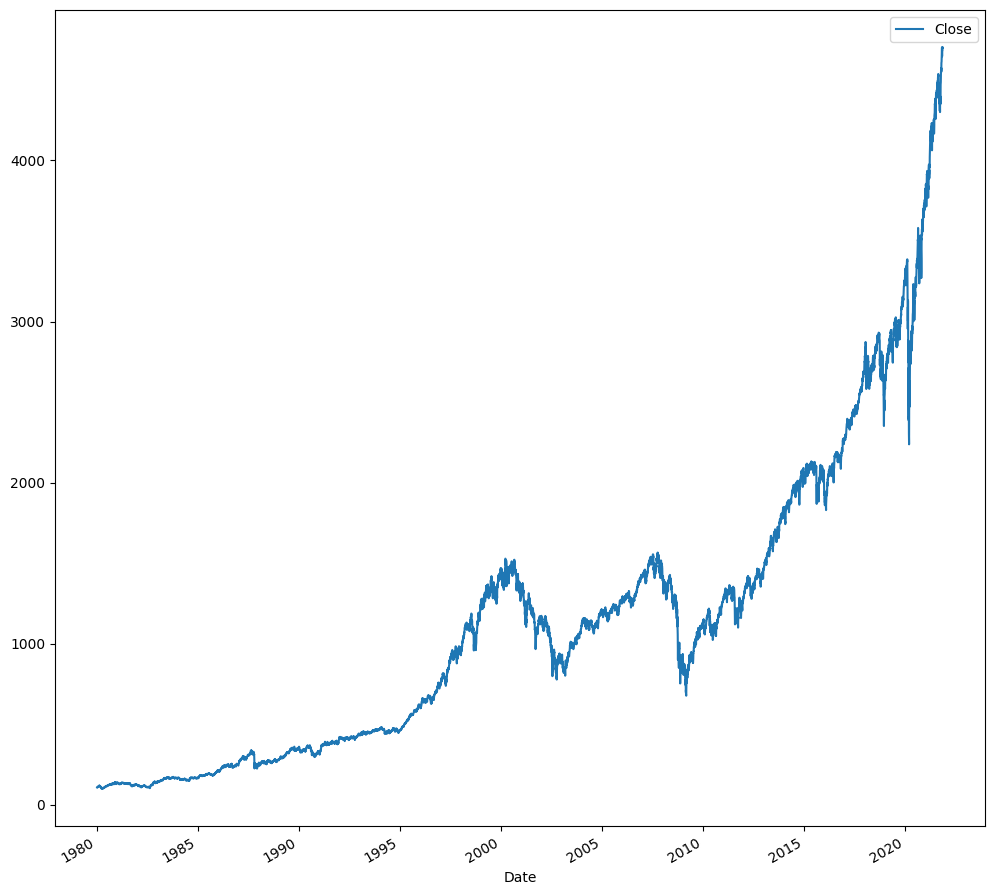

In [ ]:
# taking the close price (end of day)
sp500_data = yf.download('^GSPC', start="1980-01-01", end="2021-11-21")
sp500_data = sp500_data[['Close']]
sp500_data.plot(figsize=(12, 12))

# Decompose stock data

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

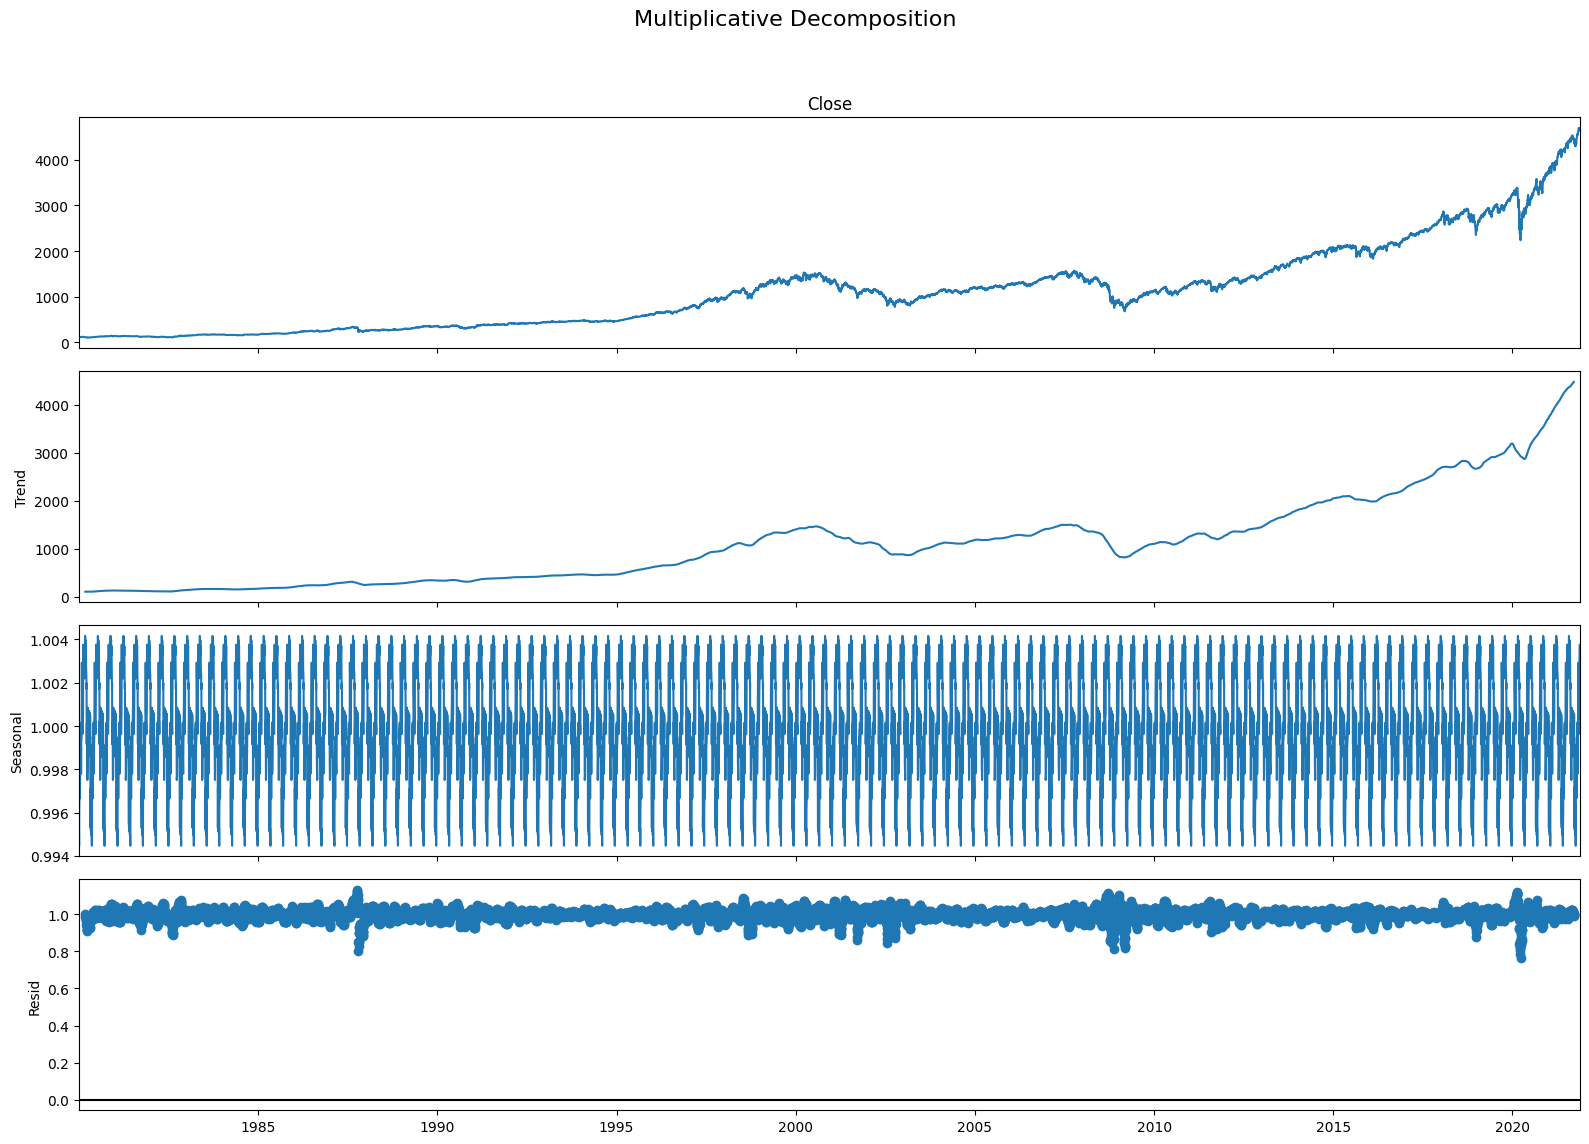

In [ ]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(sp500_data['Close'], model='multiplicative', period=90)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


There is a upward trend.

We want to know weather the price is going up or down in percentage.

<Axes: xlabel='Date'>

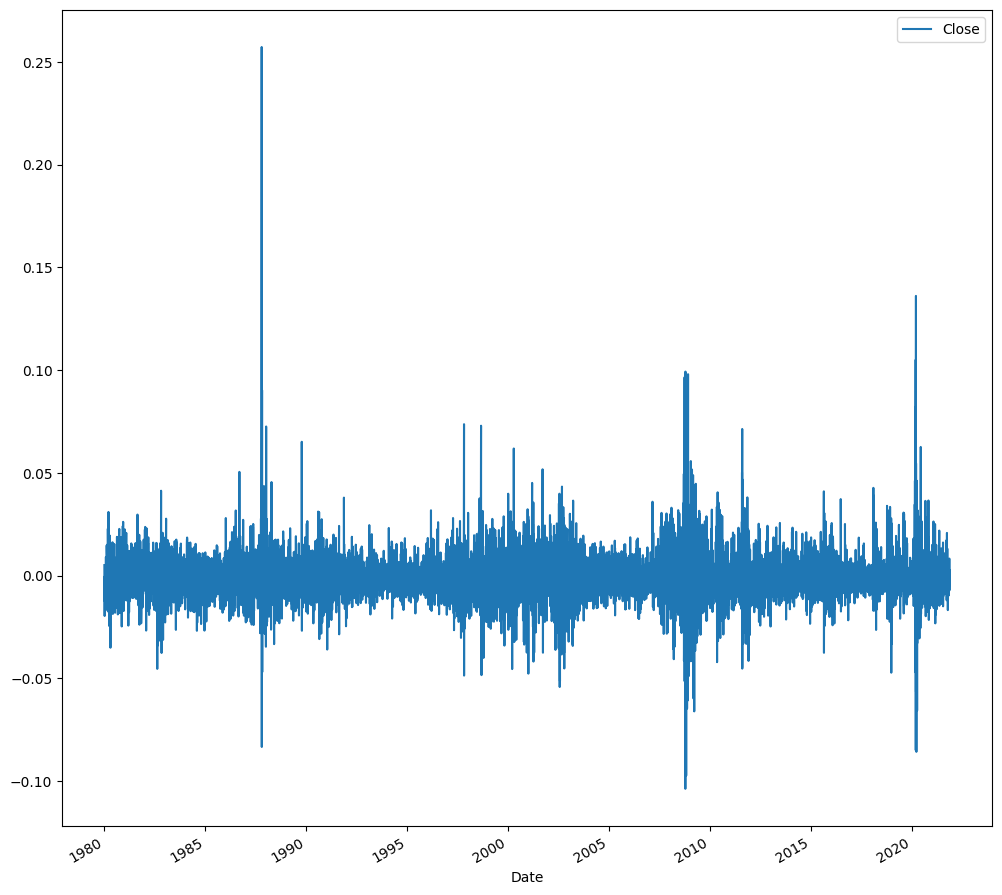

In [ ]:
difs = (sp500_data.shift() - sp500_data) / sp500_data
difs = difs.dropna()
y = difs.Close.values
difs.plot(figsize=(12, 12))

# Describe the percentage data
Before applying any statistical model on a time series, we want to ensure it’s stationary.
- Rolling Statistics: Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time.
- Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value is low

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

In [ ]:
rolling_mean = difs.rolling(window = 60).mean()
rolling_std = difs.rolling(window = 60).std()

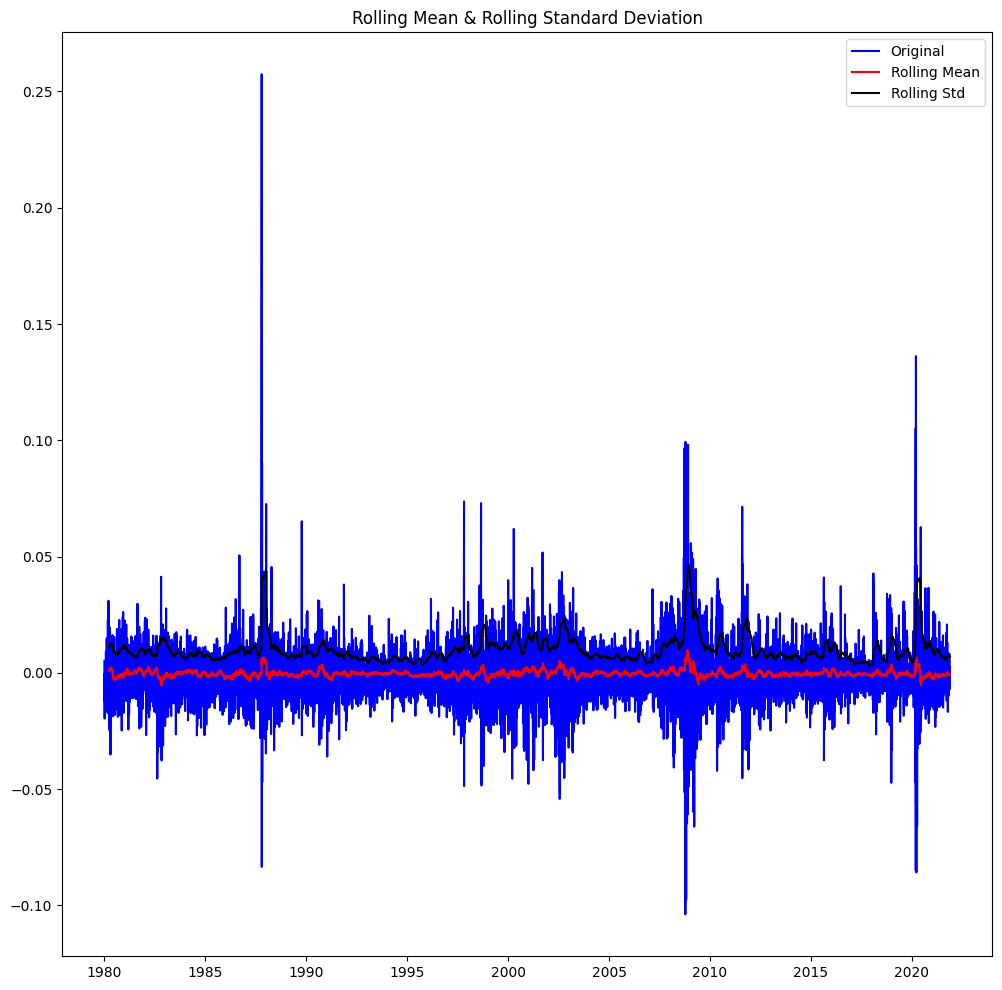

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(difs, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

The rolling mean and rolling standard deviation of percentage  is quite stable.  Therefore, we can conclude that the time series is stationary.



In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Dickey–Fuller test:
result = adfuller(difs['Close'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -17.85459502580975
p-value: 3.07005163375839e-30
Critical Values:
	1%: -3.4309712266103123
	5%: -2.861814546727005
	10%: -2.566916136080062


THe result shows the p-value of Dicky-Fuller test is larger than 0.05, which indicates that the time series is not stationary.

# Build a classical time series model using ARIMA model
Arima model considers autoregression, moving average, trends, and seasonal chages. Differencing subtracts the current value from the previous and can be used to transform a time series into one that’s stationary.
- p: number of autoregressive terms (AR order)
- d: number of nonseasonal differences (differencing order)
- q: number of moving-average terms (MA order)  

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
param_list = [(1,1,3)]

for order in param_list:

  mses = []

  tscv = TimeSeriesSplit(n_splits=100,
                          max_train_size = 3*31,
                          test_size=1)

  # Generate indices to split data into training and test set.
  for train_index, test_index in tscv.split(y):

      try:
        train = y[train_index]
        test = y[test_index]

        # for each ts split do a model
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        pred = model_fit.forecast(1)

        mse = mean_squared_error(test, pred)
        mses.append(mse)
      except:
	    # ignore models that error
        pass


  try:
      average_mse = np.mean(mses)
      std_mse = np.std(mses)
      print(f'order: {order}')
      print(f'average_mse:{average_mse}')
      print(f'std_mse:{std_mse}')

  except:
      print('None')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

order: (1, 1, 3)
average_mse:4.917997266415878e-05
std_mse:7.784373961987256e-05


# Build supervised ML model: XGBoost


In [ ]:
sp500_data = yf.download('^GSPC', start="1980-01-01", end="2021-11-21")
sp500_data = sp500_data[['Close']]


difs = (sp500_data.shift() - sp500_data) / sp500_data
difs = difs.dropna()

y = difs.Close.values

# window through the data
X_data = []
y_data = []
for i in range(len(y) - 31):
    X_data.append(y[i:i+30])
    y_data.append(y[i+30])

X_windows = np.vstack(X_data)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# specify the grid for the grid search of hyperparameter tuning
parameters={'max_depth': [2],
            'gamma': [1],
            'min_child_weight' : [2],
            'eta': [0.01]
    }

param_list = [(x, y, z, a) for x in parameters['max_depth'] for y in parameters['gamma'] for z in parameters['min_child_weight'] for a in parameters['eta']]


for params in param_list:

    mses = []

    my_kfold = KFold(n_splits=10, shuffle=True, random_state=0)

    for train_index, test_index in my_kfold.split(X_windows):


        X_train, X_test = X_windows[train_index], X_windows[test_index]
        y_train, y_test = np.array(y_data)[train_index], np.array(y_data)[test_index]

        xgb_model = xgb.XGBRegressor(max_depth=params[0],gamma=params[1], min_child_weight=params[2], eta=params[3])
        xgb_model.fit(X_train, y_train)
        preds = xgb_model.predict(X_test)

        mses.append(mean_squared_error(y_test, preds))

    average_mse = np.mean(mses)
    std_mse = np.std(mses)
    print(f'param: {params}')
    print(f'average_mse:{average_mse}')
    print(f'std_mse:{std_mse}')

param: (2, 1, 2, 0.01)
average_mse:0.00012999171956756307
std_mse:2.2653906507473173e-05


# Build a deep learning-based time series model: LSTM
 with cross-validation

In [ ]:
sp500_data = yf.download('^GSPC', start="1980-01-01", end="2021-11-21")
sp500_data = sp500_data[['Close']]
difs = (sp500_data.shift() - sp500_data) / sp500_data
difs = difs.dropna()
y = difs.Close.values

# create windows
X_data = []
y_data = []
for i in range(len(y) - 3*31):
    X_data.append(y[i:i+3*31])
    y_data.append(y[i+3*31])
X_windows = np.vstack(X_data)

# create train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_windows, np.array(y_data), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# build LSTM using tensorflow keras
import numpy as np
import tensorflow as tf
archi_list = [
              [tf.keras.layers.LSTM(32, return_sequences=True,  input_shape=(3*31,1)),
               tf.keras.layers.LSTM(32, return_sequences=True),
               tf.keras.layers.LSTM(32, return_sequences=True),
               tf.keras.layers.Dense(units=1)
               ]
]

lstm_df = {'last_mse':[]}

for archi in archi_list:
    lstm_model = tf.keras.models.Sequential(archi)
    lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                      optimizer=tf.optimizers.Adam(),
                      metrics=[tf.metrics.MeanSquaredError()]
                      )
    history = lstm_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
    lstm_df['last_mse'].append(history.history['val_mean_squared_error'][-1])


[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
197/197 [==============================] - 31s 130ms/step - loss: 1.4754e-04 - mean_squared_error: 1.4754e-04 - val_loss: 1.2382e-04 - val_mean_squared_error: 1.2382e-04
Epoch 2/10
197/197 [==============================] - 24s 124ms/step - loss: 1.4204e-04 - mean_squared_error: 1.4204e-04 - val_loss: 1.2547e-04 - val_mean_squared_error: 1.2547e-04
Epoch 3/10
197/197 [==============================] - 25s 125ms/step - loss: 1.4151e-04 - mean_squared_error: 1.4151e-04 - val_loss: 1.2533e-04 - val_mean_squared_error: 1.2533e-04
Epoch 4/10
197/197 [==============================] - 24s 123ms/step - loss: 1.4176e-04 - mean_squared_error: 1.4176e-04 - val_loss: 1.2249e-04 - val_mean_squared_error: 1.2249e-04
Epoch 5/10
197/197 [==============================] - 25s 125ms/step - loss: 1.4075e-04 - mean_squared_error: 1.4075e-04 - val_loss: 1.2197e-04 - val_mean_squared_error: 1.2197e-04
Epoch 6/10
197/197 [==============================] - 24s 120ms/step - loss: 1.4063e-04 - mean_

In [ ]:
print(lstm_df)

{'last_mse': [0.00012675487960223109]}


# Selecting the best model

- ARIMA MSE: 4.917997266415878e-05
- XGBoost MSE: 0.00012999171956756307
- LSTM MSE: 0.00012675487960223109

In conclusion ARIMA model has the best mse score.

